In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import gc

In [2]:
clicks_df = pd.read_csv('data/clicks.csv.gzip', compression='gzip', dtype={'advertiser_id':'int32','action_id':'float32','source_id':'int32','country_code':'category',\
                                                                           'latitude':'float32','longitude':'float32','carrier_id':'float32','os_minor':'category',\
                                                                           'os_major':'category','specs_brand':'category','timeToClick':'float32','touchX':'float32',\
                                                                           'touchY':'float32','ref_type':'category'}, index_col='trans_id')
clicks_df['created'] = pd.to_datetime(clicks_df['created'])
events_df = pd.read_csv('data/events.csv.gzip', compression='gzip', low_memory=False, dtype={'event_id':'int32','ref_type':'category','application_id':'int32',\
                                                                                            'attributed':'bool','device_countrycode':'category','device_city':'category',\
                                                                                            'trans_id':'category','carrier':'category','device_os':'category',\
                                                                                            'connection_type':'category'})
events_df['date'] = pd.to_datetime(events_df['date'])
events_df['wifi'].astype('bool', inplace=True)
installs_df = pd.read_csv('data/installs.csv.gzip', compression='gzip',index_col='ref_hash', dtype={'ref_type':'category','application_id':'int32',\
                                                                                              'device_brand':'category','click_hash':'float32'\
                                                                                            })
installs_df.drop(columns=['session_user_agent'], inplace=True)
installs_df['wifi'].astype('bool', inplace=True)
installs_df['created'] = pd.to_datetime(installs_df['created'])
auctions_df = pd.read_csv('data/auctions.csv.gzip', compression='gzip', low_memory=False, dtype={'country':'category','platform':'category','ref_type_id':'category'})

auctions_df['date'] = pd.to_datetime(auctions_df['date'])

print('setup done')

setup done


## Load data with datatypes result: 
### Events
Before datatypes: 402 MB

In [4]:
difference = events_df.memory_usage(index=True).sum()
print('After datatypes:', int(round(difference/1024/1024)), 'MB')
difference = 421557567-difference
print('Difference:', int(round(difference/1024/1024)), 'MB')

After datatypes: 269 MB
Difference: 133 MB


### Clicks
Before dtypes: 4 MB

In [5]:
difference = clicks_df.memory_usage(index=True).sum()
print('After datatypes:', int(round(difference/1024/1024)),'MB')
difference = 4031783-difference
print('Difference:', int(round(difference/1024/1024)),'MB')

After datatypes: 2 MB
Difference: 2 MB


### Auctions
Before dtypes: 1045 MB

In [6]:
difference = auctions_df.memory_usage(index=True).sum()
print('After datatypes:', int(round(difference/1024/1024)),'MB')
difference = 1095993944-difference
print('Difference:', int(round(difference/1024/1024)),'MB')

After datatypes: 653 MB
Difference: 392 MB


# Análisis exploratorio

## Observaciones iniciales

Los datos delimitan una franja temporal comprendida entre el 05/03/2019 a las 00:00 hs y el 13/03/2019, hasta las 23:59 hs inclusive.
En la data en crudo podemos observar la siguiente cantidad de filas y columnas (sin haber eliminado las columnas mencionadas en las consideraciones generales):


In [7]:
print(auctions_df.shape)

(19571319, 7)


In [8]:
print(clicks_df.shape)

(26351, 19)


In [9]:
print(events_df.shape)

(2494423, 22)


In [10]:
print(installs_df.shape)

(3412, 16)


Una primera aproximación para entender nuestro set de datos será llamar a las primeras filas y sus columnas.

In [11]:
auctions_df.head(5)

,auction_type_id,country,date,device_id,platform,ref_type_id,source_id
0,NaN,6333597102633388268,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0
1,NaN,6333597102633388268,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0
2,NaN,6333597102633388268,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0
3,NaN,6333597102633388268,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0
4,NaN,6333597102633388268,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0


Columnas: ['auction_type_id', 'country', 'date', 'device_id', 'platform', 'ref_type_id', 'source_id']

In [12]:
clicks_df.head(5)

,advertiser_id,action_id,source_id,created,country_code,latitude,longitude,wifi_connection,carrier_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash
trans_id,,,,,,,,,,,,,,,,,,,
iGgClCM9exiHF4K31g94XmvHEBSLKIY,2,NaN,4,2019-03-06 22:42:12.755000+00:00,6333597102633388268,1.205689,1.070234,False,1.0,6.768137412412545e+18,NaN,3.072849339937028e+18,2733035977666442898,NaN,1.563000,0.905,0.078,1891515180541284343,1904083516767779093
MMHTOJ6qKAOeIH_Eywh1KIcCaxtO9oM,0,NaN,0,2019-03-08 10:24:30.641000+00:00,6333597102633388268,1.218924,1.071209,False,4.0,3.025219449024123e+18,NaN,1.77408510258909e+18,392184377613098015,NaN,NaN,NaN,NaN,1891515180541284343,3086509764961796666
vIrEIdf9izUaWdAri6Ezk7T3nHFvNQU,0,NaN,0,2019-03-08 15:24:16.069000+00:00,6333597102633388268,1.205689,1.070234,False,6.0,5.97565607170903e+18,NaN,3.072849339937028e+18,392184377613098015,NaN,NaN,0.946,0.473,1891515180541284343,6958163894863846647
YaKxxEAs2UmZhSpRfiCO9Zpa82B_AKM,2,NaN,3,2019-03-06 03:08:51.543000+00:00,6333597102633388268,1.205689,1.070234,False,45.0,6.768137412412545e+18,NaN,3.072849339937028e+18,2733035977666442898,NaN,19.013000,0.035,0.431,1891515180541284343,4368617728156436525
X5XTOcYQovkl6yadYdAD7xioVGU9jiY,2,NaN,3,2019-03-06 03:32:55.570000+00:00,6333597102633388268,1.205689,1.070234,False,45.0,6.768137412412545e+18,NaN,3.072849339937028e+18,2733035977666442898,NaN,28.110001,0.054,0.423,1891515180541284343,4368617728156436525


Columnas: ['advertiser_id', 'action_id', 'source_id', 'created', 'country_code', 'latitude', ‘'longitude', 'wifi_connection', 'carrier_id', 'os_minor', 'agent_device', 'os_major', 'specs_brand', 'brand', 'timeToClick', 'touchX', 'touchY', 'ref_type', 'ref_hash']

In [13]:
events_df.head(5)

,date,event_id,ref_type,ref_hash,application_id,attributed,device_countrycode,device_os_version,device_brand,device_model,...,trans_id,user_agent,event_uuid,carrier,kind,device_os,wifi,connection_type,ip_address,device_language
0,2019-03-05 00:09:36.966,0,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,a9c0b263-acb2-4577-92c5-cbde5d7a5db1,2.2481569642543155e+17,5.516623e+18,7.531669329342818e+18,NaN,Cable/DSL,7858558567428669000,4.077062e+17
1,2019-03-05 00:09:38.920,1,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,1cd98205-0d97-4ec2-a019-667997dbfe7a,2.2481569642543155e+17,9.977660e+17,7.531669329342818e+18,NaN,Cable/DSL,7858558567428669000,4.077062e+17
2,2019-03-05 00:09:26.195,0,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,f02e2924-21ae-492b-b625-9021ae0a4eca,2.2481569642543155e+17,5.516623e+18,7.531669329342818e+18,NaN,Cable/DSL,7858558567428669000,4.077062e+17
3,2019-03-05 00:09:31.107,2,1891515180541284343,2688759737656491380,38,False,6333597102633388268,5.908703e+17,NaN,5.990117e+18,...,NaN,NaN,a813cf45-a36e-4668-85e2-5395f1564e98,2.2481569642543155e+17,8.561153e+18,7.531669329342818e+18,NaN,Cable/DSL,6324037615828123965,4.077062e+17
4,2019-03-09 21:00:36.585,3,1891515180541284343,2635154697734164782,38,False,6333597102633388268,7.391844e+18,NaN,5.960896e+18,...,NaN,NaN,63a4f0aa-e147-469f-8c55-4ca4f8d0e310,2.2481569642543155e+17,8.731902e+17,7.531669329342818e+18,NaN,Cable/DSL,2894495631302821483,3.301378e+18


Columnas: ['date', 'event_id', 'ref_type', 'ref_hash','application_id', 'attributed', 'device_countrycode', 'device_os_version','device_brand','device_model', ‘device_city', 'session_user_agent', 'trans_id', 'user_agent', 'event_uuid', 'carrier', 'kind', 'device_os', 'wifi', 'connection_type', 'ip_address', 'device_language']

In [14]:
installs_df.head(5)

,created,application_id,ref_type,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language
ref_hash,,,,,,,,,,,,,,,,
8464844987297247076,2019-03-13 01:43:33.445,0,1891515180541284343,NaN,False,False,6333597102633388268,3.083058605577787e+17,4.445252e+18,NaN,NaN,NaN,NaN,NaN,5529284367937637301,NaN
3250564871270161533,2019-03-13 04:58:35.078,0,1891515180541284343,NaN,False,False,6333597102633388268,3.083058605577787e+17,4.445252e+18,NaN,NaN,NaN,NaN,NaN,6098022721363533304,NaN
7953318831018100268,2019-03-13 04:20:57.666,0,1891515180541284343,NaN,False,True,6333597102633388268,5.1379920467642125e+17,6.026543e+18,NaN,0bfa9b4c-e07a-4522-b32d-138e3165ac98,Open,NaN,NaN,4636407223847323867,3.301378e+18
7953318831018100268,2019-03-13 04:20:57.698,0,1891515180541284343,NaN,False,False,6333597102633388268,5.1379920467642125e+17,6.026543e+18,NaN,NaN,NaN,NaN,NaN,4636407223847323867,NaN
8355110941557237501,2019-03-10 22:24:56.684,0,1891515180541284343,NaN,False,True,6333597102633388268,1.083368711068078e+18,7.876612e+18,NaN,8f235a8c-41bf-4399-b33d-c41577c949b0,Open,NaN,NaN,685400811232710215,3.301378e+18


Columnas: ['created', 'application_id', 'ref_type', 'click_hash', 'attributed', 'implicit', 'device_countrycode', 'device_brand', 'device_model', 'user_agent', 'event_uuid', 'kind', 'wifi', 'trans_id', 'ip_address', 'device_language']

## Interrogantes y procesamiento de datos

Una vez entendido el set de datos, como equipo de trabajo llevamos adelante una sesión de brain-storming con la siguiente pauta: ¿qué información de valor podremos hallar? ¿qué aporte le podremos realizar a Jammp?. 

Con este criterio, seleccionamos los interrogantes que consideramos de interés en el análisis y que resolveremos a continuación, aumentando la complejidad del mismo a medida que profundizamos en él.

### 1. ¿Qué franja horaria contuvo la mayor cantidad de subastas?

Sin las subastas en las que se participa a la hora de realizar una impresión, no se podrían generar los datos sobre clicks, eventos o instalaciones. Es por eso que nuestro punto de partida será conocer en qué franjas horarias tendremos más actividad, diviendo a los días del set en 24 horas, contando la cantidad de subastas en esa franja horaria, y llevándolo a un tipo de gráfico donde podremos visualizar la actividad de forma óptima: un heatmap.


In [15]:
auctions_df['hora'] = auctions_df['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
auctions_df['dia'] = auctions_df['date'].apply(lambda x: x.day_name()+' '+str(x.day))
pivot_auctions = auctions_df.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'count']
pivot_auctions = pivot_auctions.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_auctions = pivot_auctions[['Tuesday 5', 'Wednesday 6', 'Thursday 7', 'Friday 8', 'Saturday 9', 'Sunday 10', 'Monday 11', 'Tuesday 12', 'Wednesday 13']]
display(pivot_auctions)

dia,Tuesday 5,Wednesday 6,Thursday 7,Friday 8,Saturday 9,Sunday 10,Monday 11,Tuesday 12,Wednesday 13
hora,,,,,,,,,
00-01,14859,34045,33714,147676,159540,31450,203789,171154,209489
01-02,174893,121530,73944,179568,154556,75458,197885,181448,211809
02-03,155339,144125,117576,132846,137265,167307,185756,163076,185174
03-04,108498,105575,105663,96914,100093,143698,121824,117486,127790
04-05,74230,79694,69720,66466,72865,110476,87889,74506,80348
05-06,52970,49859,48781,44932,52740,81757,60412,47969,47823
06-07,38836,32616,30441,28167,35537,55342,39265,33164,32362
07-08,29149,22241,23366,21769,30032,38241,28928,26793,24590
08-09,25668,19658,25644,22414,29218,34129,29559,31447,30178


Dando como resultado un DataFrame donde el index será la franja horaria y las columnas los días, y llevándolo a un heatmap nos dará como resultado:

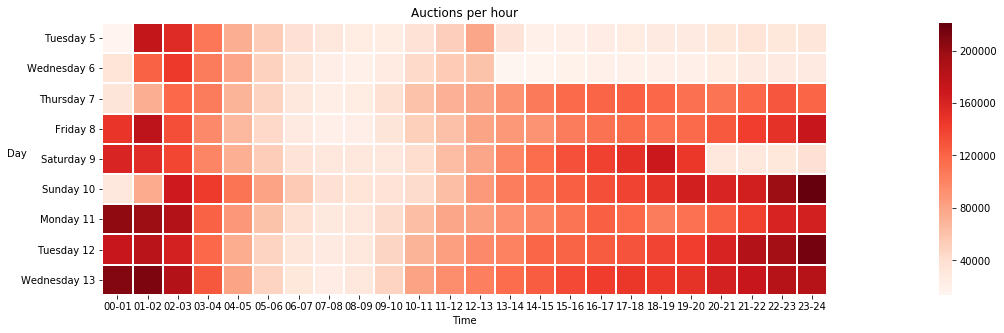

In [16]:
plt.figure(figsize = (40,5))
plt.title('Auctions per hour')
sns.heatmap(pivot_auctions.T, square = True, linewidth=1, cmap = 'Reds');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

**Conclusión 1: Podemos afirmar que la franja horaria donde más subastas se llevan a cabo es entre las 20 hs y las 3 de la mañana del día siguiente, y entre las 4 de la mañana y las 12 del mediodía cuando menos hay. Esto nos ayudará a comprender mejor el mercado.**

Luego de visualizar y analizar los valores del gráfico, surje un nuevo interrogante: 

#### a. ¿Qué sucedió los días martes 5, miércoles 6 y sábado 9 de marzo ? Tenemos valores que no siguen la lógica del resto del gráfico (a saber entre las 13hs y las 01 hs del día siguiente).

Las subastas se llevan a cabo sobre dos plataformas, platform 1 y platform 2, sea Android o iOS. Al enfocarnos en dicha inquietud, notamos que en la recopilación de datos de esos días, la cantidad de entradas de platform 1 era inusual con respecto al resto de los días. 

La probabilidad de que una subasta sea sobre platform 1 es de 0.794, casi el 80%, por lo que su peso en la cantidad de auctions es vital, y este resultado está teniendo en cuenta los valores que asumimos faltantes.


In [17]:
auctions_df['platform'].value_counts()/1000000

1    15.541825
2     4.029494
Name: platform, dtype: float64

Para visualizarlo mejor, graficamos la cantidad de eventos en platform 1 o platform 2 según el día.

In [18]:
plat1 = auctions_df.groupby(['platform','dia']).size().reset_index()
plat1.columns = ['platform','dia', 'auctions']
pivot_plat1 = plat1.pivot_table(index='dia', columns='platform', values='auctions',aggfunc='sum', fill_value=0, dropna=False)

finalPlat = pd.DataFrame(index =['Tuesday 5', 'Wednesday 6', 'Thursday 7', 'Friday 8', 'Saturday 9', 'Sunday 10', 'Monday 11', 'Tuesday 12', 'Wednesday 13'], columns = [1,2])
def func(x,y,z):
    finalPlat.loc['{}'.format(str(z))][x+1] =  pivot_plat1.loc['{}'.format(str(z))][x]
    finalPlat.loc['{}'.format(z)][y+1] =  pivot_plat1.loc['{}'.format(z)][y]
func(0,1,'Tuesday 5')
func(0,1,'Wednesday 6')
func(0,1,'Thursday 7')
func(0,1,'Friday 8')
func(0,1,'Saturday 9')
func(0,1,'Sunday 10')
func(0,1,'Monday 11')
func(0,1,'Tuesday 12')
func(0,1,'Wednesday 13')

Llevando el DataFrame resultante a un gráfico, donde podremos observar la implicancia que tiene cada plataforma sobre las subastas de los días delimitados por el set de datos.

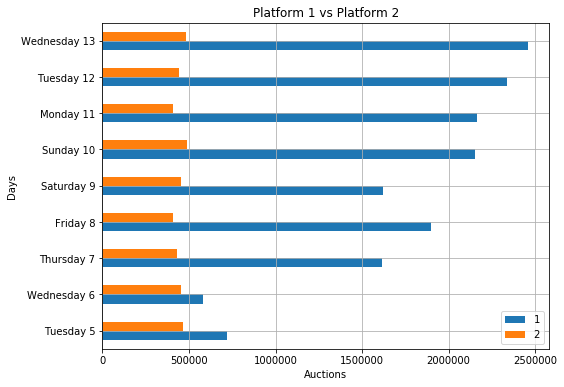

In [19]:
finalPlat.plot(kind = 'barh', figsize = (8,6), grid = True);
# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Auctions');
plt.title('Platform 1 vs Platform 2');
plt.ylabel('Days');

In [20]:
#release ram
auctions_df.drop(labels=['dia','hora'], inplace=True, axis='columns')
del pivot_auctions
gc.collect()

8144

**Conclusión 2: Existen anomalías en la toma de datos con respecto a las plataformas 1 y 2.**

### 2. Una vez que la etapa de subasta terminó y se realizó la impresión en el dispositivo, ¿dónde nuestros consumidores realizaron clicks en la pantalla? ¿por qué ahí? La concentración de clicks en la pantalla al aparecer una publicidad tienen un por qué, y es lo que intentaremos definir.

Los datos de la pantalla en el DataFrame de clicks los presentan los atributos touchX y touchY, preguntando a developers de mobile de Android y iOS nos informaron que el eje de coordenadas (0,0) en mobile se encuentra en la parte superior izquierda, eso significa que respecto a una gráfica en el eje de coordenadas (x,y) el eje Y se encuentra volcado horizontalmente y esa consideración la tomaremos en cuenta al graficar. Además, usaremos un tamaño alargado para mostrar como si fuera la pantalla de un dispositivo. 

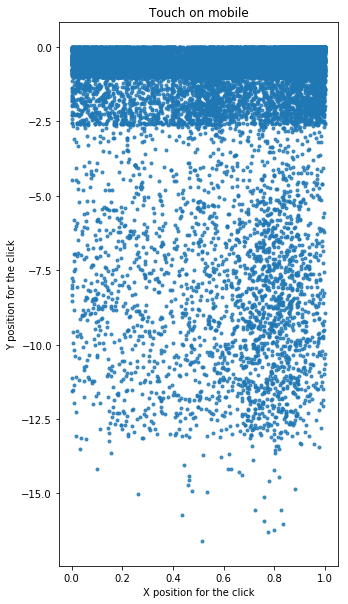

In [21]:
plt.figure(figsize = (5,10));
ax = sns.regplot(x=clicks_df[["touchX","touchY"]].dropna()["touchX"], \
                 y=-clicks_df[["touchX","touchY"]].dropna()["touchY"], marker='.',fit_reg=False);
ax.set_title('Touch on mobile');
ax.set_xlabel('X position for the click');
ax.set_ylabel('Y position for the click');

Se puede ver que en la parte superior se encuentra la mayor parte de clics. Se observa como dos bandas, y que los datos van en el eje Y hasta 16. Tomando solo datos de 0 a 1 tanto en eje X como en el Y (0 a -1) tenemos lo siguiente:

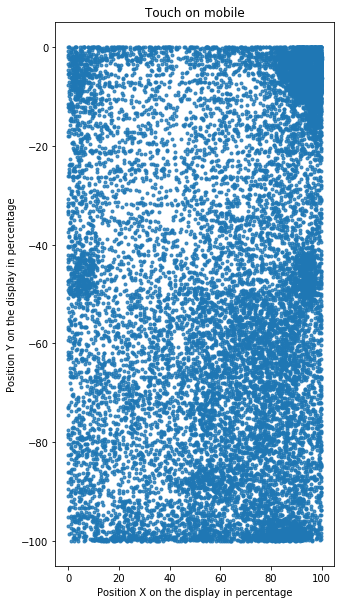

In [22]:
plt.figure(figsize = (5,10));
ax = sns.regplot(x=clicks_df.loc[clicks_df['touchY']<=1,["touchX","touchY"]].dropna()["touchX"]*100, \
                 y=-clicks_df.loc[clicks_df['touchY']<=1,["touchX","touchY"]].dropna()["touchY"]*100, \
                 marker='.',fit_reg=False);
ax.set_title('Touch on mobile');
ax.set_xlabel('Position X on the display in percentage');
ax.set_ylabel('Position Y on the display in percentage');

Para ver una concentración de los clics tenemos el siguiente código:

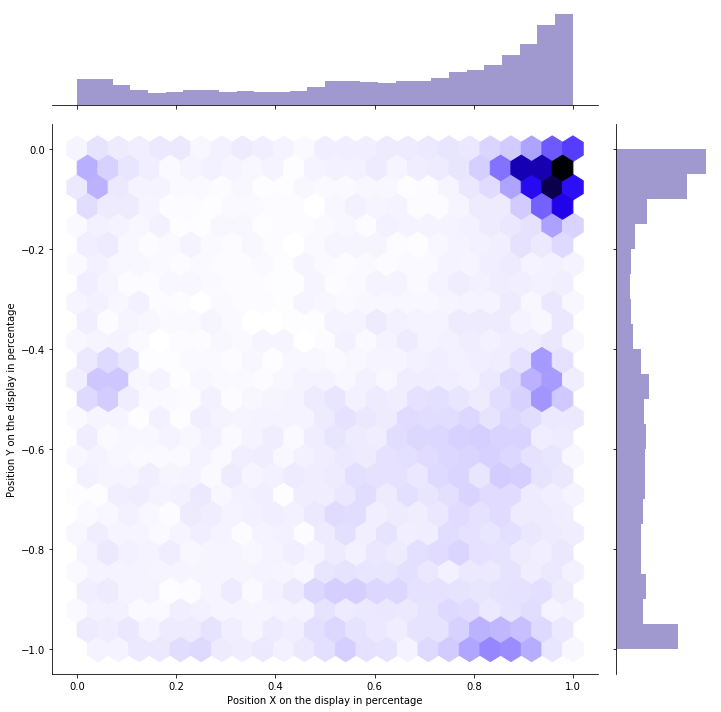

In [23]:
sns.jointplot(x=clicks_df.loc[clicks_df['touchY']<=1,["touchX","touchY"]].dropna()["touchX"],
              y=-clicks_df.loc[clicks_df['touchY']<=1,["touchX","touchY"]].dropna()["touchY"], \
              kind="hex",color='#110088', height=10) \
.set_axis_labels('Position X on the display in percentage', 'Position Y on the display in percentage');

**Conclusión: La parte superior derecha es donde está la mayor concentración. La experiencia personal nos indica que el botón de cerrar se encuentra generalmente en esa posición (no se lo puede ver alargado por la restricción de la función jointplot).**

### 3. ¿Qué franja horaria contuvo la mayor cantidad de events?


In [24]:
events_df['date'] = pd.to_datetime(events_df['date'])
events_df['hora'] = events_df['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
events_df['dia'] = events_df['date'].apply(lambda x: x.day_name()+' '+str(x.day))
pivot_events = events_df.groupby(['dia','hora']).size().reset_index()
pivot_events.columns = ['dia','hora', 'count']
pivot_events = pivot_events.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_events = pivot_events[['Tuesday 5', 'Wednesday 6', 'Thursday 7', 'Friday 8', 'Saturday 9', 'Sunday 10', 'Monday 11', 'Tuesday 12', 'Wednesday 13']]


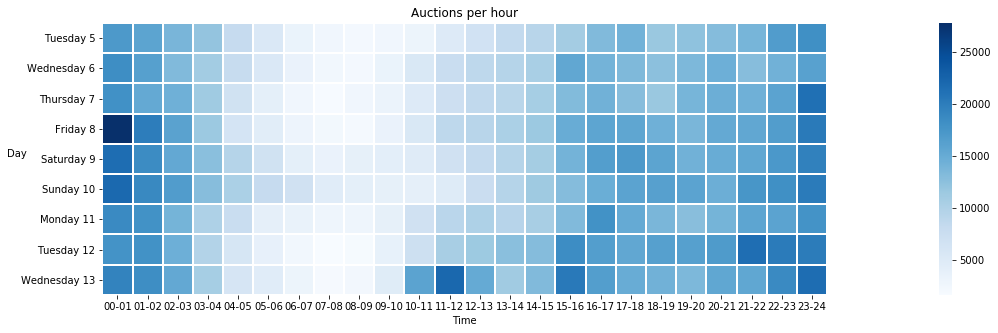

In [25]:
plt.figure(figsize = (40,5))
plt.title('Auctions per hour')
sns.heatmap(pivot_events.T, square = True, linewidth=1, cmap = 'Blues');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

In [26]:
#release ram
events_df.drop(labels=['dia','hora'], inplace=True, axis='columns')
del pivot_events
gc.collect()

4750

**Conclusión: Podemos observar como el día con mayor generación de eventos fue el viernes, y las franjas horarias a lo largo de la semana con mayor cantidad de eventos están entre las 22 hrs y las 02 hrs. Encontrándose el pico de 23 a 01 hrs. Podemos suponer que en estos horarios los usuarios ya se encuentran en la comodidad de su hogar (con conexión wifi, tema que trataremos más adelante).**

De manera singular, también encontramos un pico el miércoles 13 entre 10 y 13 hrs, con punto máximo entre las 11 y 12 hrs, Llama la atención que ese suele ser un horario en general no tan frecuente, pero por la hora podría tratarse de eventos tipo delivery de comida (para el almuerzo), o q fueron generados al estar el usuario con el celular durante su break del almuerzo. 

A su vez, en general de 4 a 10 horas, la frecuencia de conversiones de eventos baja considerablemente a poco más de 1/5 de la mayor frecuencia observada.

Dicho heatmap se encuentra en sintonía con el heatmap anterior de la cantidad de subastas, tiene sentido que haya más subastas en los horarios donde se generan más eventos.

### 4. ¿Cuáles clicks generaron conversiones en events?

Los clicks que generan conversiones en events se muestran en el siguiente gráfico:


In [27]:
auct_click = pd.merge(auctions_df[['device_id']], clicks_df[['ref_hash', 'touchX', 'touchY']], how='inner', left_on='device_id', right_on='ref_hash')

In [28]:
click_event = pd.merge(auct_click, events_df[['ref_hash']], how='inner', on='ref_hash')

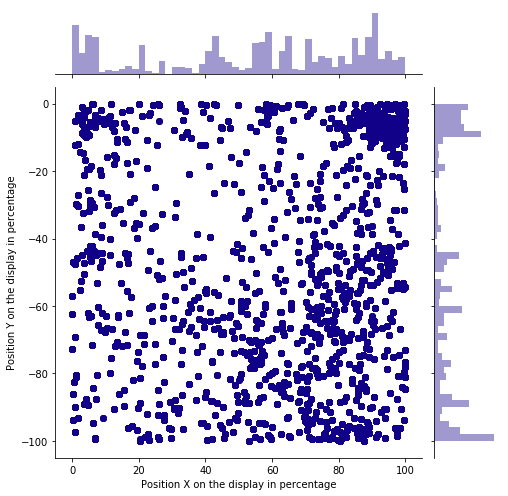

In [29]:
sns.jointplot(x=click_event.loc[(click_event['touchY']<=1), ["touchX","touchY"]].dropna()["touchX"]*100, \
              y=-click_event.loc[(click_event['touchY']<=1), ["touchX","touchY"]].dropna()["touchY"]*100, \
              color='#110088', height=7) \
.set_axis_labels('Position X on the display in percentage', 'Position Y on the display in percentage');

En un gráfico de concentración de clics tenemos:

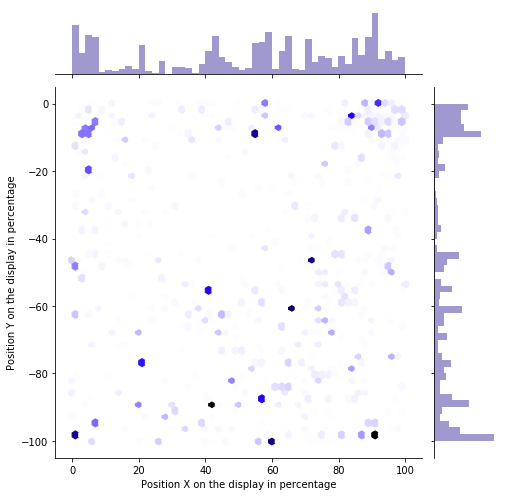

In [30]:
sns.jointplot(x=click_event.loc[click_event['touchY']<=1,["touchX","touchY"]].dropna()["touchX"]*100,
              y=-click_event.loc[click_event['touchY']<=1,["touchX","touchY"]].dropna()["touchY"]*100, \
              kind="hex",color='#110088', height=7) \
.set_axis_labels('Position X on the display in percentage', 'Position Y on the display in percentage');

In [31]:
#release ram
del click_event
gc.collect()

22379

### 5. ¿En qué franja horaria se produjo la mayor cantidad de instalaciones?

Se utilizó la misma lógica antes mencionada para su análisis.

In [32]:
installs_df['hora'] = installs_df['created'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
installs_df['dia'] = installs_df['created'].apply(lambda x: x.day_name()+' '+str(x.day))
pivot_installs = installs_df.groupby(['dia','hora']).size().reset_index()
pivot_installs.columns = ['dia','hora', 'count']
pivot_installs = pivot_installs.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_installs = pivot_installs[['Tuesday 5', 'Wednesday 6', 'Thursday 7', 'Friday 8', 'Saturday 9', 'Sunday 10', 'Monday 11', 'Tuesday 12', 'Wednesday 13']]

Graficando el Data Frame obtenido tenemos:

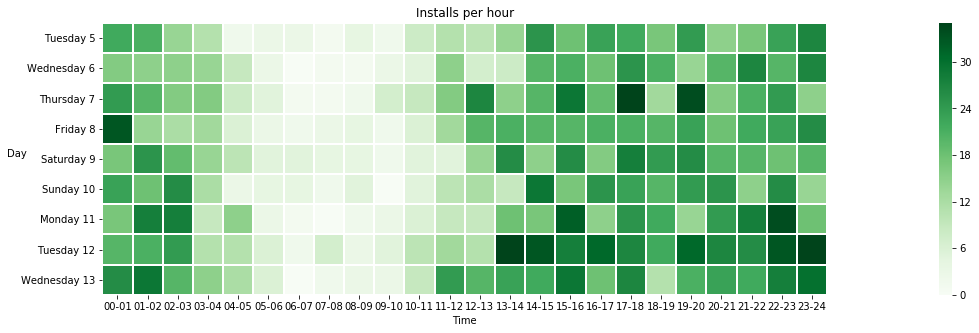

In [33]:
plt.figure(figsize = (40,5));
plt.title('Installs per hour');
sns.heatmap(pivot_installs.T, square = True, linewidth=1, cmap = 'Greens');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

**Conclusión: los horarios en los que se hallaron más installs siguen un comportamiento similar al de los events, la mayor cantidad sigue produciéndose entre las 17 horas y las 2 de la mañana.**

In [34]:
#release ram
installs_df.drop(labels=['dia', 'hora'], axis='columns', inplace=True)
del pivot_installs
gc.collect()

4770

### 6. ¿Cuáles fueron las 4 aplicaciones más instaladas?

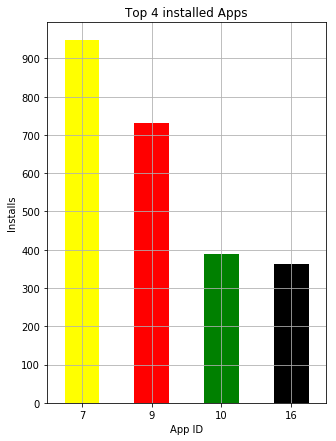

In [35]:
installs_df['application_id'].value_counts().sort_values(ascending = False).head(4).plot(kind = 'bar', grid = True, figsize = (5,7), color=['yellow', 'red', 'green', 'black'])
plt.xticks(rotation = 0);
plt.title('Top 4 installed Apps');
plt.xlabel('App ID');
yticks = range(0,1000,100);
plt.yticks(yticks);
plt.ylabel('Installs');

**Conclusión: La aplicación más instalada fue la App ID, seguida por la App ID 9 en segundo lugar. Es recomendable generar impresiones para estas apps, ya que es más factible que sean instaladas.**

### 7. ¿Estar conectado a internet vía wifi tuvo peso a la hora de definir si el consumidor instaló ?

In [36]:
(sum(installs_df['wifi'].isnull()) / len(installs_df['wifi'])) * 100

49.32590855803048

Tendremos 49.33% valores nulos no considerados, al ser de tipo True or False, no podemos completar los valores sin afectar el resultado final.

In [37]:
#DE TODOS LOS INSTALLS QUE PROPORCIÓN UTILIZÓ WIFI ?
wifiSs = installs_df['wifi']
wifiSs.dropna(inplace = True)
(sum(wifiSs == True)) / (len(wifiSs))

0.7964141122035859

**Conclusión 1: El 79.64% de las instalaciones fueron a través de una red wifi.**

In [38]:
#Porcentaje de no atribuciones a Jammp
print(sum(installs_df['attributed'] == False) / (len(installs_df['attributed']))*100)

100.0


**Conclusión 2: 0% installs atribuídos a Jammp durante la franja temporal del set de datos.**

### 8. ¿Cuáles fueron las Apps más instaladas con wifi?

In [39]:
installs_df.reset_index(inplace=True)

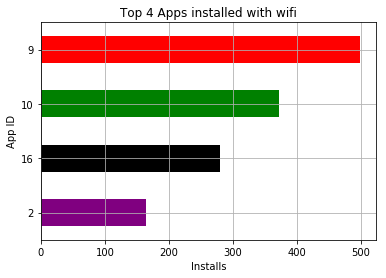

In [40]:
installs_df.loc[installs_df['wifi']==True]['application_id'].value_counts().head(4).sort_values(ascending = True)\
.plot(kind = 'barh',  color=['purple', 'black', 'green', 'red'], grid = True);
plt.title('Top 4 Apps installed with wifi');
plt.xlabel('Installs');
plt.ylabel('App ID');

**Conclusión: Podemos observar como la gran mayoría de los installs del App ID 9 fueron mediante conexión wifi, es decir, es recomendable participar de una subasta para realizar una impresión de esta app, si sabemos que el consumidor está conectado a una red wifi, por otro lado, la App ID 7 fue instalada mayormente cuando no se estaba conectado a wifi. **

Puede deberse a que la aplicación del App ID 9 sea pesado y se busque no utilizar datos móviles para su instalación.

### 9. Si el tipo de conexión en installs tuvo gran importancia ¿tendrá un peso similar la conexión vía wifi en los eventos?

In [41]:
#SESGO POR NULOS
sum(events_df['wifi'].isnull()) / len(events_df['wifi']) *100

44.721805403494116

44.72% de valores nulos no considerados, al ser de tipo True or False, no podemos completar los valores sin afectar el resultado final.

In [42]:
#Mismo para events
#DE TODOS LOS EVENTS QUE PROPORCIÓN UTILIZÓ WIFI ?
#SUMO LOS PROMEDIOS
#events_wifiSs = eventsDF['wifi']
events_with_wifi = (sum(events_df['wifi'] == True)) / (len(events_df['wifi'].dropna()))
events_with_wifi*100

67.51185026601453

**Conclusión 1: 67.51%  de los eventos fueron generados estando conectado a una red wifi.**

In [43]:
#Porcentaje de atribuciones a Jammp en eventos
events_df['attributed'].value_counts()
(sum(events_df['attributed'] == True) ) / (len(events_df['attributed'].dropna())) *100

0.20441601123786943

**Conclusión 2: 0.20441601123786943%  fue atribuído a Jammp**

In [44]:
#Que probabilidad hay de que se genere un evento favorable a Jammp sabiendo que la persona estaba conectada a la red WIFI
EJ = (sum(events_df['attributed'] == True) )/ (len(events_df['attributed'].dropna())) 
events_with_wifi
noEJ = (sum(events_df['attributed'] == False) )/ (len(events_df['attributed'].dropna()))
#Teorema de bayes
'El porcentaje de eventos atribuídos a Jammp sabiendo que la persona estaba conectada a la red Wi-Fi es {}'\
.format( (EJ*events_with_wifi)*100 / ( (EJ*events_with_wifi) + (noEJ*events_with_wifi)))

'El porcentaje de eventos atribuídos a Jammp sabiendo que la persona estaba conectada a la red Wi-Fi es 0.2044160112378694'

**Conclusión 3: 0.2044160112378694% atribuído a Jammp sabiendo que estaba conectado a wifi, por el teorema de Bayes.**

No se redondearon los porcentajes para notar la diferencia entre los porcentajes.

### 10. ¿Cuáles clicks generaron conversiones en installs?

Los clicks que generan conversiones en installs se muestran en el siguiente gráfico:

In [45]:
click_install = pd.merge(auct_click, installs_df[['ref_hash']], how='inner', on='ref_hash')

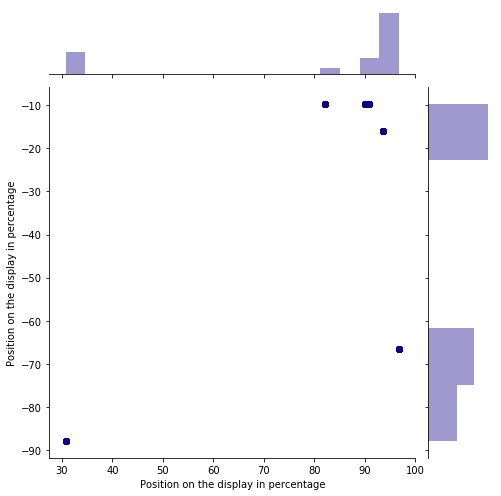

In [46]:
sns.jointplot(x=click_install.loc[(click_install['touchY']<=1), ["touchX","touchY"]].dropna()["touchX"]*100, \
              y=-click_install.loc[(click_install['touchY']<=1), ["touchX","touchY"]].dropna()["touchY"]*100,\
              color='#110088', height=7) \
.set_axis_labels('Position on the display in percentage', 'Position on the display in percentage');

En el gráfico anterior no se necesita un gráfico de concentración ya que son pocas las conversiones en installs

In [47]:
#release ram
del auct_click
del click_install
gc.collect()

12540

### 11. ¿Cuáles fueron las distribuciones de los eventos de la muestra ?¿Y de los installs?

Graficando la cantidad de events por device tenemos lo siguiente

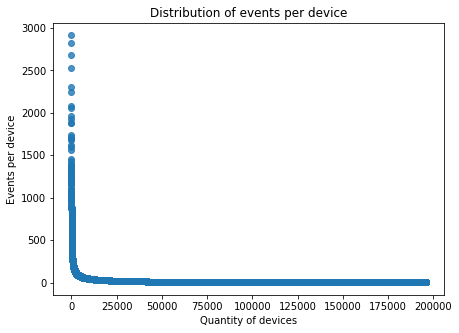

In [48]:
plt.figure(figsize = (7,5));
device_freq = events_df['ref_hash'].value_counts().to_frame().reset_index().reset_index()
device_freq.columns = ['x', 'ref_hash', 'count']

ax = sns.regplot(x=device_freq['x'], y=device_freq['count'], fit_reg=False);
ax.set_xlabel('Quantity of devices');
ax.set_ylabel('Events per device');
ax.set_title('Distribution of events per device');

Se ve una distribución en `L` casi perfecta y acomodando el gráfico a una escala log-log tenemos:

/Users/sergiolch/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


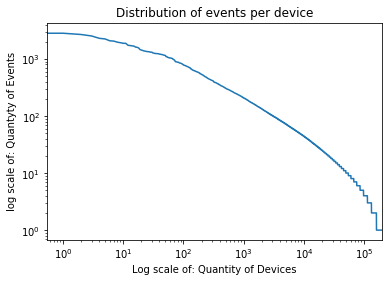

In [49]:
ax = device_freq.plot(x='x',y='count',loglog=True, legend=False);
ax.set_xlabel('Log scale of: Quantity of Devices');
ax.set_ylabel('log scale of: Quantyty of Events');
ax.set_title('Distribution of events per device');

**Conclusión 1: Se puede ver que el gráfico presenta una pendiente negativa por lo cual los events muestran una distribución de Zipf **

La ley de Zipf que determina la frecuencia de las palabras en los textos en inglés, plantea que la palabra más común, “the”, aparece el doble de veces que la segunda, “of”, el triple que la tercera, el cuádruple que la cuarta y así. 

Pudimos observar que este fenómeno se da también en la distribución de los eventos generados. Es decir, el evento más generado, tiene el doble de ocurrencias que el segundo más generado, el triple que el tercero, etc. Por lo que unos pocos eventos acaparan la mayor cantidad de conversiones. 

El determinar qué tipo de eventos tienen mayor cantidad de conversiones, es de gran utilidad para Jampp, ya que puede influir en la frecuencia con que presente publicidad para esos eventos, y definiendo una menor para los eventos más bajos de la distribución. Esto es posible que esté relacionado con la vertical del cliente al que pertenezca el evento.

Al hacer el mismo cálculo para el dataframe de installs tenemos lo siguiente: 

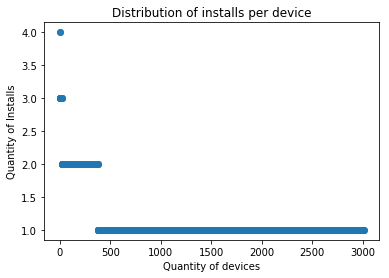

In [50]:
# vamos a graficar la cantidad de installs que se tienen por device
device_freq2 = installs_df.reset_index()['ref_hash'].value_counts()\
.to_frame().reset_index().reset_index()
device_freq2.columns = ['x', 'ref_hash', 'count']

ax = sns.regplot(x=device_freq2['x'], y=device_freq2['count'], fit_reg=False);
ax.set_xlabel('Quantity of devices');
ax.set_ylabel('Quantity of Installs');
ax.set_title('Distribution of installs per device');

**Conclusión 2: Aquí vemos que  o no cumple la ley de Zifp o no tenemos suficientes datos como en events**

### 12. ¿Cuáles fueron los tiempos de conversión ?

El tiempo de conversión se lo calcula:

In [51]:
#tiempo desde el auction hasta el install menor a 3 dias
tiempo_install = pd.merge(auctions_df[['device_id','date']], installs_df[['ref_hash','created']], how='inner', left_on='device_id', right_on='ref_hash')
tiempo_install = tiempo_install[['device_id', 'created', 'date']]
tiempo_install['tiempo_convert'] = tiempo_install['created']-tiempo_install['date']
tiempo_install = tiempo_install.loc[(tiempo_install['tiempo_convert']>'0 days') & (tiempo_install['tiempo_convert']<'3 days')]

In [52]:
#tiempo desde el auction hasta el event menor a 3 dias
tiempo_event = pd.merge(auctions_df[['device_id', 'date']], events_df[['ref_hash', 'date']], how='inner', left_on='device_id', right_on='ref_hash')
tiempo_event['tiempo_convert'] = tiempo_event['date_x']-tiempo_event['date_y']
tiempo_event = tiempo_event.loc[(tiempo_event['tiempo_convert']>'0 days') & (tiempo_event['tiempo_convert']<'3 days')]

In [53]:
#cuanto se tadró en convertir
tiempo_convert = tiempo_event[['device_id','tiempo_convert']].append(tiempo_install[['device_id','tiempo_convert']])
tiempo_convert['tiempo_convert_int'] = tiempo_convert['tiempo_convert'].astype(np.int64)
timpo_promedio_final = tiempo_convert.groupby('device_id').agg({'tiempo_convert_int':'mean'})

#delete when no longer needed
del tiempo_convert
del tiempo_event
del tiempo_install
#collect residual garbage
gc.collect()

timpo_promedio_final['tiempo_convert'] = pd.to_timedelta(timpo_promedio_final['tiempo_convert_int'])
timpo_promedio_final['tiempo_convert_int'] = timpo_promedio_final['tiempo_convert_int']/(1000000000*60*60) #time in hours
display(timpo_promedio_final.sort_values(by='tiempo_convert_int').head(5))
display(timpo_promedio_final.sort_values(by='tiempo_convert_int',ascending=False).head(5))

,tiempo_convert_int,tiempo_convert
device_id,,
6476136897640051683,0.000104,00:00:00.373865
8879285412621886200,0.000109,00:00:00.392986
7726309491409335088,0.000113,00:00:00.406538
2660291393840202520,0.000280,00:00:01.007727
1060905180031510488,0.000386,00:00:01.388022


,tiempo_convert_int,tiempo_convert
device_id,,
2388483969818950144,71.999939,2 days 23:59:59.779375
5384808367700175776,71.990600,2 days 23:59:26.160695
6186960712873908907,71.985311,2 days 23:59:07.120210
4248988661908265614,71.977620,2 days 23:58:39.433272
2506280281326444943,71.974854,2 days 23:58:29.474364


Las estadisticas del tiempo

In [54]:
timpo_promedio_final['tiempo_convert'].describe()

count                     64129
mean     1 days 08:18:03.241788
std      0 days 16:31:56.341358
min      0 days 00:00:00.373865
25%      0 days 20:54:53.277348
50%      1 days 08:33:51.973624
75%      1 days 19:20:11.183846
max      2 days 23:59:59.779375
Name: tiempo_convert, dtype: object

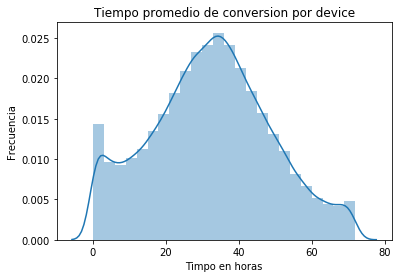

In [55]:
ax = sns.distplot(timpo_promedio_final['tiempo_convert_int'], bins=24);
ax.set_xlabel('Timpo en horas');
ax.set_ylabel('Frecuencia');
ax.set_title('Tiempo promedio de conversion por device');

El tiempo promedio de dispositivos reaparezca en la subasta se calcula de la siguiente manera: 

In [56]:
## Cuánto tiempo promedio entre publicidades por device id
#def time_between(x):
#    # diferencia entre elementos de la lista
#    device_dates = x.dropna().sort_values().tolist();
#    if len(device_dates)<2:
#        return np.nan
#    diff = [j-i for i, j in zip(device_dates[:-1], device_dates[1:])]
#    return np.sum(diff)/len(diff)
#auctionsDF[['device_id', 'date']].head(2).T
#tiempo_entre = auctionsDF.groupby('device_id').agg({'date': time_between})
#tiempo_entre['date_int'] = tiempo_entre['date'].astype(np.int64)/(1000000000*60) #tiempo en minutos
#display(tiempo_entre.head(5))

In [58]:
# para no ejecutar el anterior script, el resulta lo guardamos preciamente en un csv
tiempo_entre = pd.read_csv('data/tiempo_entre.csv', index_col='device_id')
tiempo_entre.dropna(inplace=True)
tiempo_entre['date'] = pd.to_timedelta(tiempo_entre['date'])
tiempo_entre['date_int'] = tiempo_entre['date'].astype(np.int64)/(1000000000*60) #tiempo en minutos

In [59]:
tiempo_entre['date'].describe()

count                      1923
mean     0 days 00:07:54.140841
std      0 days 00:09:35.499620
min      0 days 00:00:00.006781
25%      0 days 00:01:15.191176
50%      0 days 00:04:21.769474
75%      0 days 00:10:34.330056
max      0 days 00:52:42.660945
Name: date, dtype: object

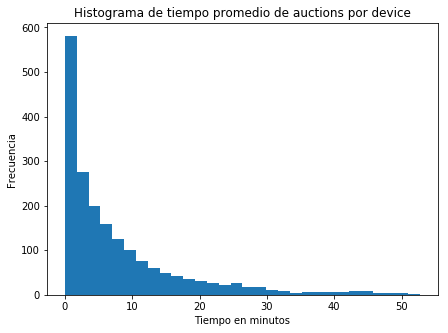

In [60]:
plt.figure(figsize = (7,5))
ax = tiempo_entre['date_int'].plot.hist(bins=30)
ax.set_xlabel('Tiempo en minutos');
ax.set_ylabel('Frecuencia');
ax.set_title('Histograma de tiempo promedio de auctions por device');

**Conclusión: Conversiones:**
- **tiempo promedio de conversión: 1 days 08:18:03.241788**
- **tiempo promedio de dispositivos reaparezca en la subasta:  0 days 00:07:54.140841**

### 13. ¿Cuál fue la distribución de los eventos de Jammp ? Los más frecuentes. 

Como paso inicial para el análisis de los eventos, observamos que tipo de distribución presentan los eventos atribuidos a Jampp.

In [61]:
#investigando al User con device ID 4153352203585747855 que cuenta con 158 eventos
user1DF=events_df.loc[events_df['ref_hash']==4153352203585747855]

In [62]:
user1_dayDF = user1DF.loc[user1DF['attributed']==True].groupby(['event_id','application_id','attributed','ip_address','date']).size().reset_index().rename(columns={0:'total'})

Ahora, visualizamos también la distribución de eventos atribuidos a Jampp para corroborar que corresponden a una distribución similar a la general.

Text(0, 0.5, 'Frequency')

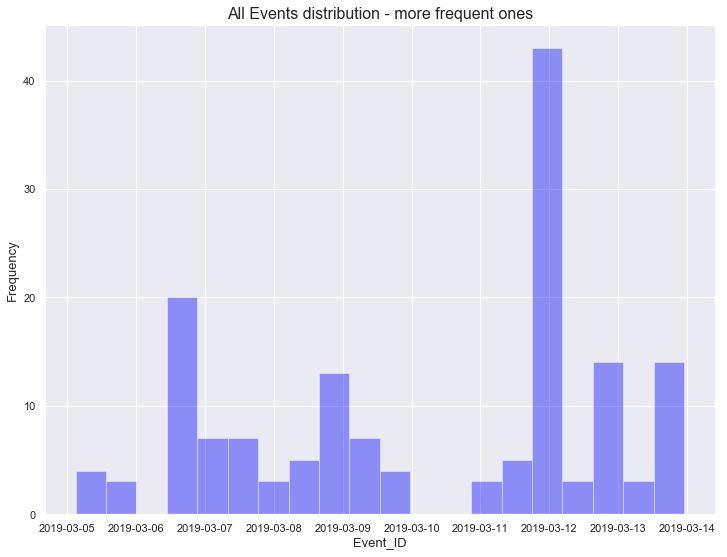

In [63]:
#visualizamos en el tiempo
# Distribucion/cantidad de eventos 
sns.set(rc={'figure.figsize':(12,9)})
#primero para el DF de eventos total
sns.distplot(user1_dayDF['date'], bins=20, color='blue', kde=False)
#ahora para el DF de eventos atribuidos a jampp
#sns.distplot( events_jamppDF['event_id'], bins=100, color='blue', label='Eventos de Jampp')
#plt.legend(prop={'size': 12})
plt.title('All Events distribution - more frequent ones', fontsize=16)
plt.xlabel('Event_ID', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
#sns.plt.show()


**Conclusión: unos pocos eventos tienen la mayor frecuencia de ocurrencia, y la mayoría por el contrario, tiene una mínima ocurrencia. **

### 14. Eventos por usuario.

Para poder identificar si hay algún “outlier” o dato anómalo en la muestra, visualizamos la cantidad de eventos por usuario con un histograma lollipop para resaltar los datos que se alejen más de la media.

In [64]:
#events per user solo de jampp
events_x_userDF = events_df.loc[events_df['attributed']==True].groupby(['ref_hash']).size().reset_index().rename(columns={0:'total'})

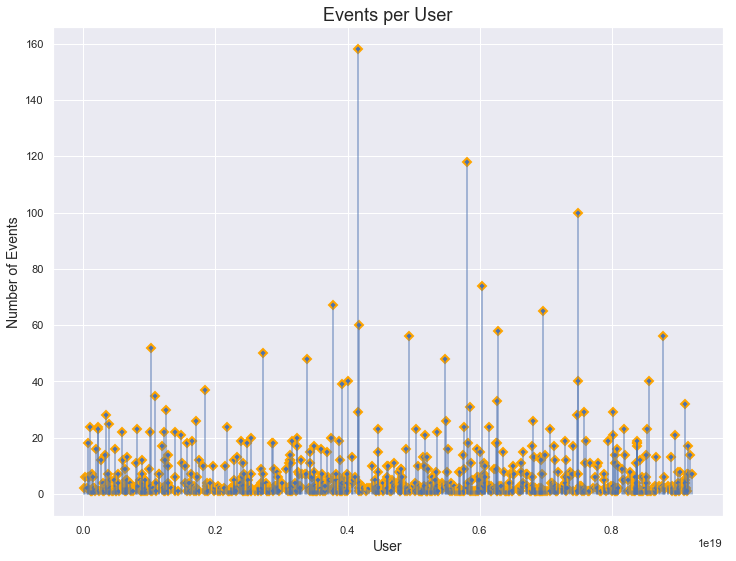

In [65]:
#Visualización lollipop de eventos por usuario
plt.title('Events per User', fontsize=18);
plt.xlabel('User', fontsize=14);
plt.ylabel('Number of Events', fontsize=14);
(markerline, stemlines, baseline) = plt.stem(events_x_userDF['ref_hash'], events_x_userDF['total'])
# change color and shape and size and edges
plt.setp(markerline, marker='D', markersize=5, markeredgecolor="orange", markeredgewidth=2);
plt.setp(stemlines, alpha=0.6 );
plt.setp(baseline, visible=False);
#plt.show()

Se identifican 3 usuarios que se despegan considerablemente de la media por lo cual los excluimos de la muestra para analizarlos por separado y descartar que sean “outliers”. Podría incluso tratarse de fraude de acuerdo al resto de las características. 

In [66]:
# get the top value
events_x_userDF.loc[events_x_userDF['total'].idxmax()]

ref_hash    4153352203585747855
total                       158
Name: 311, dtype: int64

De manera similar con los dos siguientes valores a este.

Recalculamos el dataframe extrayendo esos valores por medio del siguiente código:

In [67]:
# Excluyendo esos 3 valores, volvemos a analizar la distribución
events_withoutDF = events_df.loc[~events_df['ref_hash'].isin([4153352203585747855,5811896797087419802,7486989802522901338])]

In [68]:
# Recalculamos el DF sin esos valores
events_x_userDF = events_withoutDF.loc[events_withoutDF['attributed']==True].groupby(['ref_hash']).size().reset_index().rename(columns={0:'total'})
events_x_userDF.shape

(706, 2)

Y nuevamente visualizamos:

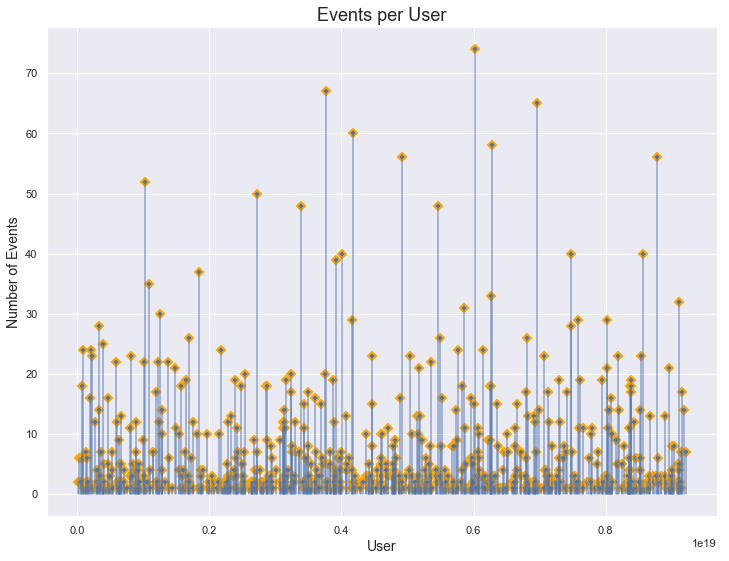

In [69]:
#lollipop plot de events x user (Jampp)
plt.title('Events per User', fontsize=18);
plt.xlabel('User', fontsize=14);
plt.ylabel('Number of Events', fontsize=14);
(markerline, stemlines, baseline) = plt.stem(events_x_userDF['ref_hash'], events_x_userDF['total'])
# change color and shape and size and edges
plt.setp(markerline, marker='D', markersize=5, markeredgecolor="orange", markeredgewidth=2);
plt.setp(stemlines, alpha=0.6);
plt.setp(baseline, visible=False);

Revisamos la información estadística antes y después (ver tablas a continuación), como es esperado, la dispersión de los datos es reducida, sin embargo aún se puede observar una gran distancia entre la media, el mínimo y máximo:

In [70]:
#Datos estadísticos de la distribución
events_x_userDF.describe()

,ref_hash,total
count,7.060000e+02,706.000000
mean,4.664898e+18,6.689802
std,2.653634e+18,9.560191
min,3.734549e+15,1.000000
25%,2.492897e+18,1.000000
50%,4.783660e+18,3.000000
75%,6.906046e+18,8.000000
max,9.220804e+18,74.000000


Para mejorar la visualización y evitar el “overplotting”, realizamos una por densidad 2D.

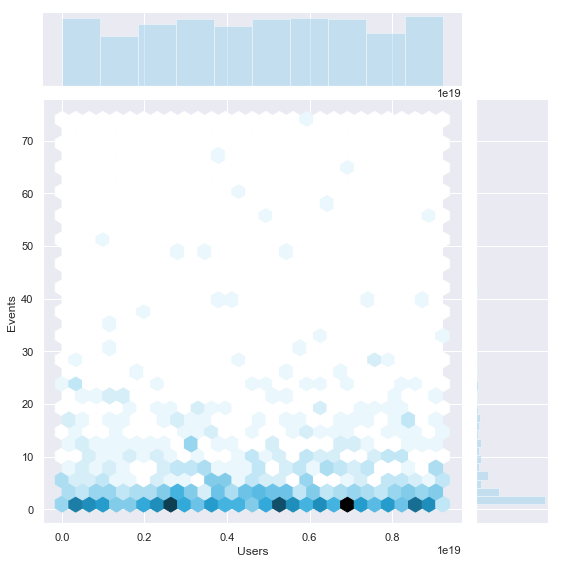

In [71]:
#Cual es la correlación entre users and events?
#SCATTER plot

#DENSITY HEXBIN CHART
sns.jointplot(x=events_x_userDF['ref_hash'], y=events_x_userDF['total'], kind='hex', height=8, color="skyblue").set_axis_labels('Users','Events');

**Conclusión: Podemos observar que la mayoría de los usuarios tienen un sólo evento, a raíz de la intensidad de color de los puntos hexagonales en la parte inferior del eje Y, casi pegados al eje X.**

A su vez, la mayor cantidad de eventos convertidos a favor de Jampp, son realizados por unos pocos usuarios.

De esto podemos inferir que la probabilidad de que los usuarios con mayor cantidad de eventos sigan convirtiendo, es bastante elevada. Son una especie de “clientes frecuentes” para determinados eventos. 

Es necesario considerar también la vertical del negocio (cliente de Jampp)  al que pertenece el evento, ya que un juego, una orden de delivery de comida, tienen más chance de repetirse en un corto periodo de tiempo, que por ejemplo, la compra de un pasaje aéreo.

### 15. Eventos por aplicación.

Continuamos el análisis de los eventos, según la aplicación en la que fueron convertidos.

In [72]:
events_appDF = events_df.loc[events_df['attributed']==True].groupby(['application_id']).size().reset_index().rename(columns={0:'total'})

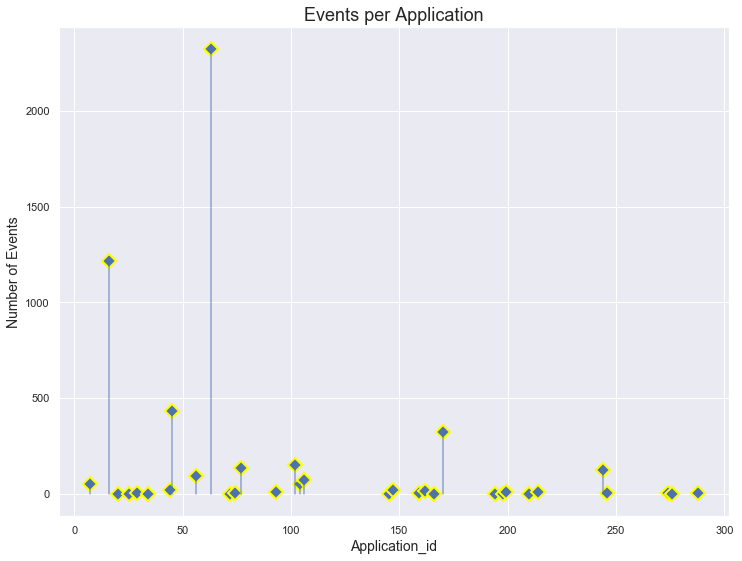

In [73]:
#lollipop plot de events x app (Jampp)
plt.title('Events per Application', fontsize=18);
plt.xlabel('Application_id', fontsize=14);
plt.ylabel('Number of Events', fontsize=14);
(markerline, stemlines, baseline) = plt.stem(events_appDF['application_id'], events_appDF['total'])
# change color and shape and size and edges
plt.setp(markerline, marker='D', markersize=10, markeredgecolor="yellow", markeredgewidth=2);
plt.setp(stemlines, alpha=0.6);
plt.setp(baseline, visible=False);

De manera similar que con los eventos por usuario, se observa unos pocos con mayor cantidad de conversiones, y la gran mayoría con conversiones mínimas o 1 sola. Sin embargo, al tratarse de eventos tiene sentido que este escenario se presente, por lo que no vamos a quitar esos datos de la muestra.

In [74]:
#se observan 2 valores que se alejan mucho de la media
events_appDF.describe()

,application_id,total
count,33.000000,33.000000
mean,129.060606,154.515152
std,85.443307,449.360179
min,7.000000,1.000000
25%,56.000000,2.000000
50%,106.000000,8.000000
75%,198.000000,75.000000
max,288.000000,2323.000000


Para evitar el overpplotting debido a la cantidad de datos, una vez más creamos una visualización marginal plot. 

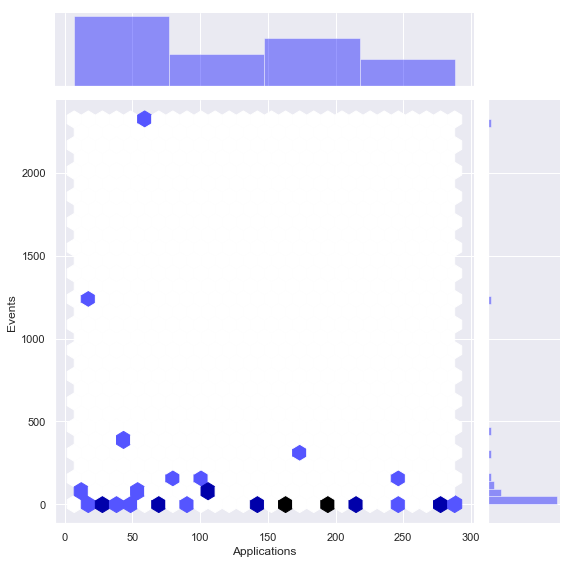

In [75]:
#DENSITY CHART
sns.jointplot(x=events_appDF['application_id'], y=events_appDF['total'], kind='hex', height=8, color='blue')\
.set_axis_labels('Applications','Events');

**Conclusión: Podemos observar claramente como la mayoría de las aplicaciones tienen una incidencia baja de cantidad de eventos que se produzcan por publicidad mostrada en las mismas.**

De hecho, de 33 aplicaciones observadas acá, aprox el 50 % 17 llegan a un máximo de 7 eventos. Por otro lado, se observan 2 que se despegan del resto en más de 1000 y 2000 eventos generados.  

Eso ya nos da un indicio de el impacto del tipo de aplicacion, ya sea por popularidad o a que vertical pertenece, en la conversión de eventos.

### 16. ¿Se intersectarán los clicks e installs según el usuario? ¿Existirá una proporción?

Para una mirada general de los datos recibidos y el flujo de un usuario a través de ellos, desde que recibe la publicidad (Clicks DF) y genera una conversión (Installs / Events DF), presentamos la siguiente visualización:

In [76]:
#Installs, events y clicks por usario
installs_x_userDF = installs_df.groupby(['ref_hash']).size().reset_index().rename(columns={0:'total'})
clicks_x_userDF = clicks_df.groupby(['ref_hash']).size().reset_index().rename(columns={0:'total'})
#al haber eventos atribuidos de Jampp, nos interesa tomar esos y no el total para este caso
events_x_userDF = events_df.loc[events_df['attributed']==True].groupby(['ref_hash']).size().reset_index().rename(columns={0:'total'})

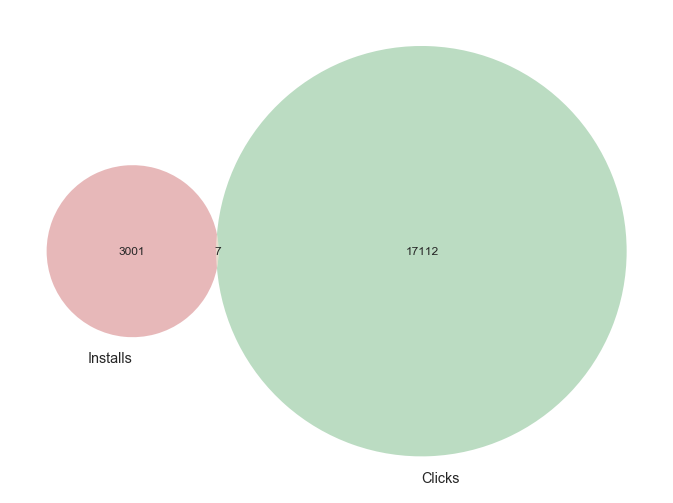

In [77]:
venn2([set(installs_x_userDF['ref_hash']), set(clicks_x_userDF['ref_hash'])], set_labels=('Installs', 'Clicks'))
plt.show()

De manera similar para los eventos, pero considerando solamente los atribuidos a Jampp

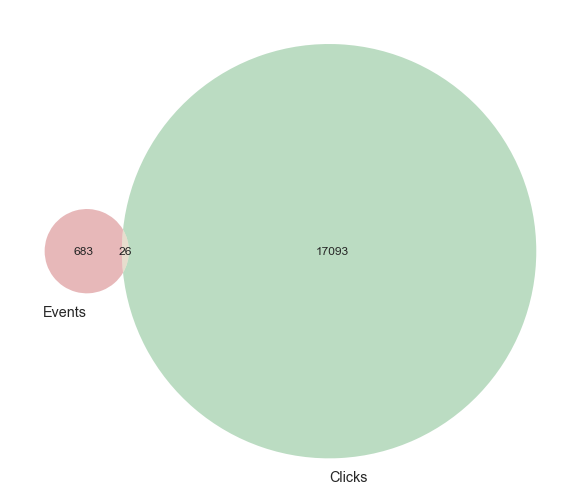

In [78]:
venn2([set(events_x_userDF['ref_hash']), set (clicks_x_userDF['ref_hash'])], set_labels=('Events', 'Clicks'))
plt.show()

**Conclusión: Observamos una bajisima proporción entre ambos grupos, siendo Clicks aproximadamente cuatro veces más grande que los Eventos que llegan a convertirse. Sin embargo, de estos mismo no sabemos cuántos clicks corresponden especificamente a los eventos registrados ya que la muestra de Clicks implica tanto las isntalaciones, los eventos, así como las no conversiones.**

### 17. ¿Existirá una relación entre los clientes y las aplicaciones ?

Ante la pregunta que nos surgió en cuanto al impacto de la aplicación en la que se presenta la publicidad frente al cliente, ya sea por la vertical del negocio a la que pertenezca por ejemplo, realizamos el siguiente análisis.

Primero, hacemos un join entre los dataframes clicks y events para poder visualizar esta relación.

In [79]:
#Para poder observar si hay alguna conducta o relación interesante entre los clientes y las aplicaciones, hacemos un merge de ambos DFs: Clicks y Events
clicks_eventsDF = pd.merge(events_df, clicks_df, on='ref_hash', how='inner')
clicks_eventsDF.shape

(23655, 40)

Y seguidamente la visualización para ver los datos más claramente y hallar los clientes con mayor éxito en la conversión de eventos.

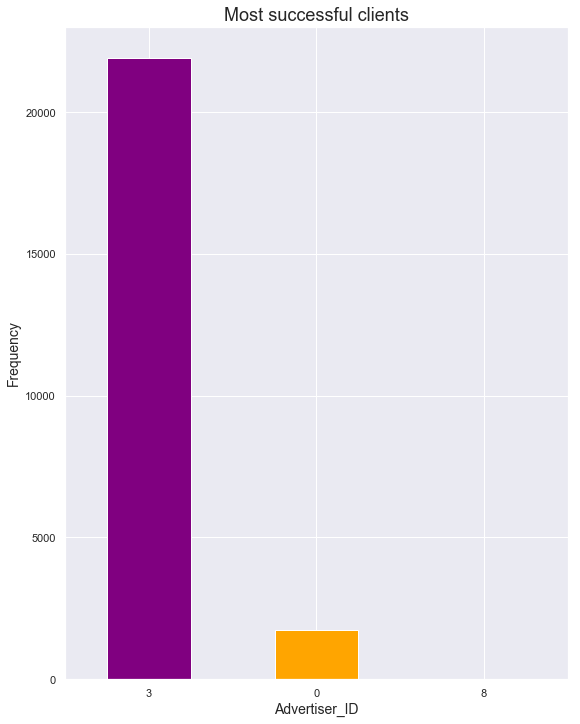

In [80]:
#HAcemos la visualiación para identificar los clientes con más exito de conversiones
clicks_eventsDF['advertiser_id'].value_counts().sort_values(ascending = False).plot(kind = 'bar', grid = True, figsize = (9,12), color=['purple', 'orange']);
plt.xticks(rotation = 0);
plt.title('Most successful clients', fontsize=18);
plt.xlabel('Advertiser_ID', fontsize=14);
#plt.yticks(yticks)
plt.ylabel('Frequency', fontsize=14);

**Conclusión 1: Los tres clientes de la muestra con mayor número de conversiones de retargetting, son el Cliente 3, Cliente 0 y Cliente 8, con los siguientes totales. Nótese la gran diferencia entre el Cliente 3 y los otros, observemos los totales para cada cliente a continuación.**

In [81]:
clicks_eventsDF['advertiser_id'].value_counts().sort_values(ascending = False)

3    21923
0     1727
8        5
Name: advertiser_id, dtype: int64

Ahora es necesario profundizar un poco más en este análisis para los clientes puntuales de Jampp.

### Relación entre los clientes de Jampp, las aplicaciones y los eventos generados 

La correlación entre el cliente y la aplicación en la que se muestra su publicidad al usuario, puede proporcionar información valiosa en cuanto a la búsqueda de patrones. Es decir, si el cliente A genera mayor cantidad de eventos en la aplicación X que en Y, ante un nuevo cliente B que pertenezca a la misma vertical que A, es probable que ocurra lo mismo.

El código a continuación conecta tanto el dataframe de clicks que contiene el código de cliente (advertiser_id) con el de events que presenta el código de la aplicación (application_id) para posteriormente hacer la visualización.


In [82]:
# DF de relación events and clicks para clientes de Jampp
events_x_clientjDF = clicks_eventsDF.loc[clicks_eventsDF['attributed']==True].groupby(['advertiser_id','application_id']).size().reset_index().rename(columns={0:'total'})

El gráfico a continuación muestra esta relación entre ambas variables, antes mencionadas, el cliente y la aplicación y la cantidad de eventos generados por la relación de las mismas determina el tamaño de la burbuja.

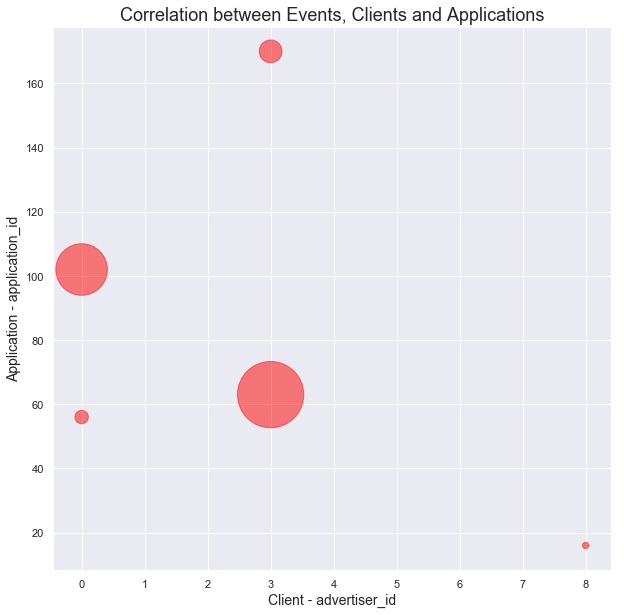

In [83]:
#Bubble pot para observar la relación entre events, clients and applications
x = events_x_clientjDF['advertiser_id']
y = events_x_clientjDF['application_id']
z = events_x_clientjDF['total']
plt.figure(figsize = (10,10));
# use the scatter function
plt.scatter(x, y, s=z*20, c="red", alpha=0.5);
# Add titles (main and on axis)
plt.xlabel('Client - advertiser_id', fontsize=14);
plt.ylabel('Application - application_id', fontsize=14);
plt.title('Correlation between Events, Clients and Applications', fontsize=18);
plt.show()

**Conclusión 1: De lo anterior podemos observar que el Cliente 3 tiene mejor resultado, 220 eventos con cuando la aplicación en la que se muestra su publicidad es la 63, que cuando va a la aplicación 170 con la que sólo obtiene 28 conversiones.**

In [84]:
#Eventos para el cliente 3 y las dos aplicaciones donde se mostró su publicidad
events_x_clientjDF.loc[events_x_clientjDF['advertiser_id']==3]

,advertiser_id,application_id,total
2,3,63,220
3,3,170,26


**Conclusión 2: A su vez, para el cliente 0, tiene mejor resultado cuando su publicidad es mostrada en la aplicación 102, que en la 56.**

In [85]:
#Eventos para el cliente 0 y las dos aplicaciones donde se mostró su publicidad
events_x_clientjDF.loc[events_x_clientjDF['advertiser_id']==0]

,advertiser_id,application_id,total
0,0,56,9
1,0,102,133


### Relación entre los clientes, las aplicaciones y las instalaciones generadas 

Si bien la muestra no contiene ninguna conversión para Jampp dentro de las instalaciones, un análisis similar al previo puede indicarnos en general, con qué aplicación tienen más éxito.

In [86]:
clicks_installsDF = pd.merge(installs_df[['ref_hash','application_id']], clicks_df[['ref_hash','advertiser_id']], on='ref_hash', how='inner')

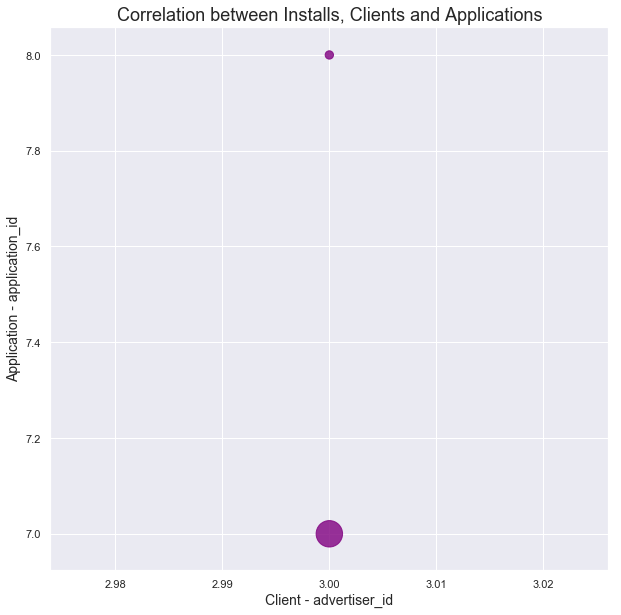

In [87]:
# DF de relación installs and clicks para clientes 
installs_x_clientDF = clicks_installsDF.groupby(['advertiser_id','application_id']).size().reset_index().rename(columns={0:'total'})
#Bubble pot para observar la relación entre installs, clients and applications. Al no haber atribuidas a jampp, se toma la muestra total
x = installs_x_clientDF['advertiser_id']
y = installs_x_clientDF['application_id']
z = installs_x_clientDF['total']
plt.figure(figsize = (10,10));
# use the scatter function
plt.scatter(x, y, s=z*70, c='purple', alpha=0.8);
# Add titles (main and on axis)
plt.xlabel('Client - advertiser_id', fontsize=14);
plt.ylabel('Application - application_id', fontsize=14);
plt.title('Correlation between Installs, Clients and Applications', fontsize=18);
plt.show()

**Conclusión: No es una sorpresa que nuevamente el Cliente 3 aparezca en el top 1 y en una proporción de conversiones similar a la observada en los eventos.**

# Consideraciones finales: 

El presente trabajo presentó un gran desafío para nosotros como grupo de oyentes, donde nuestra formación académica no es homogénea, y en nuestra opinión abre el abánico de posibilidades para trabajar con el set de datos otorgado por la empresa Jammp. 

El tener experiencia en otras áreas permite, en términos de Edward de Bono, generar un pensamiento lateral, una forma creativa de organizar los procesos lógicos no ortodoxos, para generar un nuevo resultado. 

Creemos que la oportunidad de cursar esta materia con personas no pertenecientes a nuestro rubro no solamente aportará valor a Jammp, sino que a nosotros mismos y a nuestra vida profesional.